In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal

%matplotlib widget

In [2]:
# we're working with 3-dimensional data
# this 3-D random vector X takes values from a mixture of four Guassians
# the first gaussian is the class-conditional pdf for class 1, and antoher is for class 2
# the remaining 2 gaussian components are the class-conditional pdfs for class 3 with equal weights
# the class priors are p1 = 0.3, p2 = 0.3, p3 = 0.4
# we want to set the distances between the means of pairs of gaussians to twice the average standard deviation

# set up the parameters of the class-conditioned Gaussian pdfs
# the distances between the means of pairs of gaussians are set to twice the average standard deviation
sigma_1 = np.eye(3)
sigma_2 = np.eye(3)
sigma_3 = np.eye(3)
sigma_4 = np.eye(3)

avg_std = np.sqrt(np.trace(sigma_1) + np.trace(sigma_2) + np.trace(sigma_3) + np.trace(sigma_4)) / 4

mult = 1.5 * avg_std

mu_1 = np.array([mult, mult, mult])
mu_2 = np.array([0, mult, mult])
mu_3 = np.array([mult, 0, mult])
mu_4 = np.array([mult, mult, 0])

# set up the parameters of the class priors
p_1 = 0.3
p_2 = 0.3
p_3 = 0.4

# verify that the distances between the means of pairs of gaussians are set to twice the average standard deviation
print("The distance between mu_1 and mu_2 is", np.linalg.norm(mu_1 - mu_2))
print("The distance between mu_2 and mu_3 is", np.linalg.norm(mu_2 - mu_3))
print("The distance between mu_3 and mu_4 is", np.linalg.norm(mu_3 - mu_4))
print("The distance between mu_4 and mu_1 is", np.linalg.norm(mu_4 - mu_1))
print("The distance between mu_1 and mu_3 is", np.linalg.norm(mu_1 - mu_3))
print("The distance between mu_2 and mu_4 is", np.linalg.norm(mu_2 - mu_4))
print("Twice the average standard deviation is", 2 * avg_std)

The distance between mu_1 and mu_2 is 1.299038105676658
The distance between mu_2 and mu_3 is 1.8371173070873836
The distance between mu_3 and mu_4 is 1.8371173070873836
The distance between mu_4 and mu_1 is 1.299038105676658
The distance between mu_1 and mu_3 is 1.299038105676658
The distance between mu_2 and mu_4 is 1.8371173070873836
Twice the average standard deviation is 1.7320508075688772


### Part A
#### 1. Generate 10000 samples from this data distribution and keep track of the true class labels

In [3]:
# generate 10000 samples from this data distribution and keep track of the true class labels
samples = 10000
gaussian_1 = np.random.multivariate_normal(mu_1, sigma_1, samples)
gaussian_2 = np.random.multivariate_normal(mu_2, sigma_2, samples)
gaussian_3 = np.random.multivariate_normal(mu_3, sigma_3, samples)
gaussian_4 = np.random.multivariate_normal(mu_4, sigma_4, samples)

data = []
labels = []

# use the class priors to generate the labels
for i in range(samples):
    # class 1
    if np.random.rand() < p_1:
        data.append(gaussian_1[i])
        labels.append(1)
    # class 2
    elif np.random.rand() < p_1 + p_2:
        data.append(gaussian_2[i])
        labels.append(2)
    # class 3
    elif np.random.rand() < p_1 + p_2 + p_3:
        # class 3 data originates from a mixture of gaussians 3 and 4 with equal weights
        if np.random.rand() < 0.5:
            data.append(gaussian_3[i])
            labels.append(3)
        else:
            data.append(gaussian_4[i])
            labels.append(3)

# convert the data and labels to numpy arrays
data = np.array(data)
labels = np.array(labels)

#### 2. Specify the decision rule that acheives minimum probability of error (use 0-1 loss). Implement this classifier with true data distribution knowledge. Classify the 10k samples and count the samples corresponding to each decision-label pair to empirically estimate the confusion matrix.

In [4]:
# likelihood estimation to use in the decision rule
# the likelihood of a sample x is the probability of x given the class label
# the likelihood of x given class 1 is the pdf of the multivariate gaussian with mean mu_1 and covariance sigma_1 evaluated at x
# the likelihood of x given class 2 is the pdf of the multivariate gaussian with mean mu_2 and covariance sigma_2 evaluated at x
# the likelihood of x given class 3 is the pdf of the multivariate gaussians with means mu_3, mu_4 and covariances sigma_3, sigma_4 equally weighted evaluated at x 
def likelihood(x: np.array, label: int) -> float:
    """
    Given a sample x and a class label, return the likelihood of x given the class label

    Args:
        x (np.array): a sample
        label (int): a class label

    Raises:
        ValueError: if the label is not 1, 2, or 3

    Returns:
        float: the likelihood of x given the class label
    """
    if label == 1:
        return multivariate_normal.pdf(x, mu_1, sigma_1)
    elif label == 2:
        return multivariate_normal.pdf(x, mu_2, sigma_2)
    elif label == 3:
        return 0.5 * multivariate_normal.pdf(x, mu_3, sigma_3) + 0.5 * multivariate_normal.pdf(x, mu_4, sigma_4)
    else:
        raise ValueError("Invalid label")

In [5]:
# the decision rule is to choose the class label that maximizes the likelihood of the sample
# the decision rule is implemented with true data distribution knowledge
# the decision rule is implemented with true class priors
def minimum_probability_error_rule(x: np.array, loss: np.array) -> int:
    """
    Given a sample x and a loss matrix, return the class label that minimizes the probability of error

    Args:
        x (np.array): a sample
        loss (np.array): the loss matrix

    Returns:
        int: the class label that minimizes the probability of error
    """
    # compute the likelihoods of x given each class label
    likelihoods = [likelihood(x, 1), likelihood(x, 2), likelihood(x, 3)]

    # calculate the posterior probabilities of x given each class label
    # the posterior probability of x given class 1 is the likelihood of x given class 1 times the class prior of class 1
    # the posterior probability of x given class 2 is the likelihood of x given class 2 times the class prior of class 2
    # the posterior probability of x given class 3 is the likelihood of x given class 3 times the class prior of class 3
    posterior_probs = [likelihoods[0] * p_1, likelihoods[1] * p_2, likelihoods[2] * p_3]

    # calculate the expected loss of each class label
    loss_1 = posterior_probs[0] * loss[0][0] + posterior_probs[1] * loss[0][1] + posterior_probs[2] * loss[0][2]
    loss_2 = posterior_probs[0] * loss[1][0] + posterior_probs[1] * loss[1][1] + posterior_probs[2] * loss[1][2]
    loss_3 = posterior_probs[0] * loss[2][0] + posterior_probs[1] * loss[2][1] + posterior_probs[2] * loss[2][2]

    # return the class label that minimizes the expected loss
    return np.argmin([loss_1, loss_2, loss_3]) + 1

In [6]:
# classify the 10k samples and count the samples corresponding to each decision-label pair to empirically estimate the confusion matrix
# we're using 0-1 loss 
loss_1 = np.array([[0, 1, 1], [1, 0, 1], [1, 1, 0]])

confusion_matrix = np.zeros((3, 3), dtype=int)

for i in range(samples):
    guess = minimum_probability_error_rule(data[i], loss_1)
    confusion_matrix[labels[i] - 1][guess - 1] += 1

# print the confusion matrix
print("The confusion matrix is")
print(confusion_matrix)

The confusion matrix is
[[1356  610 1066]
 [ 669 2703  782]
 [ 456  325 2033]]


#### 3. Provide a vizualization of the data (scatter plot in 3 dimensions). For each sample, indicate the true class label with a different marker and if it was correctly classified with a different color


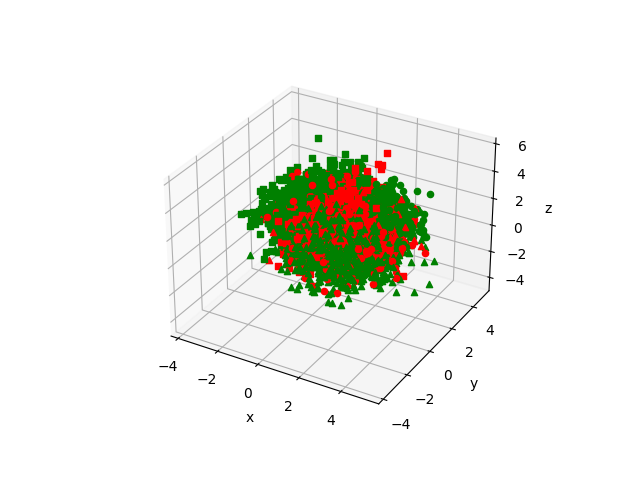

In [8]:
# plot the data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# plot the samples
for i in range(samples):
    # determine the color to use
    color = 'green' if labels[i] == minimum_probability_error_rule(data[i], loss_1) else 'red'
    
    # determine the marker to use
    marker = 'o' if labels[i] == 1 else 's' if labels[i] == 2 else '^'

    # plot the sample
    ax.scatter(data[i][0], data[i][1], data[i][2], c=color, marker=marker)

# label the axes
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

# show the plot
plt.show()

### Part B
#### Repeat the exercise for the ERM classificaiton rule with the following loss matrices. Using the same 10k samples, estimate the minimum expected risk that this optimal ERM classification rule will achieve.


In [9]:
loss_10 = np.array([[0, 1, 10],
                    [1, 0, 10],
                    [1, 1, 0]])

loss_100 = np.array([[0, 1, 100],
                     [1, 0, 100],
                     [1, 1, 0]])

confusion_matrix_10 = np.zeros((3, 3), dtype=int)

for i in range(samples):
    guess = minimum_probability_error_rule(data[i], loss_10)
    confusion_matrix_10[labels[i] - 1][guess - 1] += 1

# print the confusion matrix
print("The confusion matrix for caring 10x more is")
print(confusion_matrix_10)

confusion_matrix_100 = np.zeros((3, 3), dtype=int)

for i in range(samples):
    guess = minimum_probability_error_rule(data[i], loss_100)
    confusion_matrix_100[labels[i] - 1][guess - 1] += 1

# print the confusion matrix
print("The confusion matrix for caring 100x more is")
print(confusion_matrix_100)

The confusion matrix for caring 10x more is
[[  36  102 2894]
 [  29  909 3216]
 [   0   23 2791]]
The confusion matrix for caring 100x more is
[[   0    4 3028]
 [   0   66 4088]
 [   0    1 2813]]


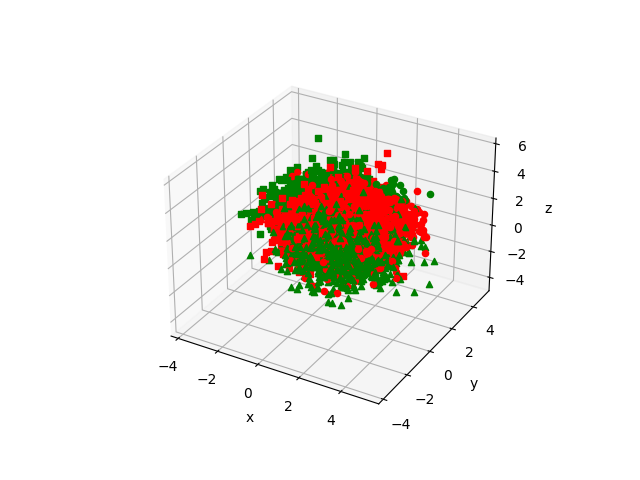

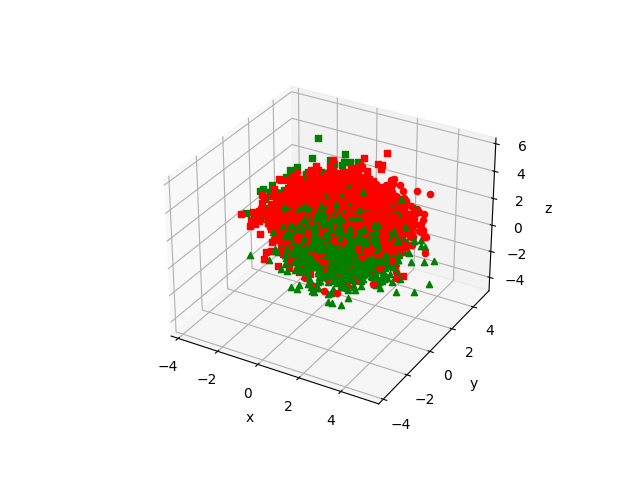

In [15]:
# plot the data for the 10x loss
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# plot the samples
for i in range(samples):
    # determine the color to use
    color = 'green' if labels[i] == minimum_probability_error_rule(data[i], loss_10) else 'red'
    
    # determine the marker to use
    marker = 'o' if labels[i] == 1 else 's' if labels[i] == 2 else '^'

    # plot the sample
    ax.scatter(data[i][0], data[i][1], data[i][2], c=color, marker=marker)

# label the axes
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

# show the plot
plt.show()

# plot the data for the 100x loss
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# plot the samples
for i in range(samples):
    # determine the color to use
    color = 'green' if labels[i] == minimum_probability_error_rule(data[i], loss_100) else 'red'
    
    # determine the marker to use
    marker = 'o' if labels[i] == 1 else 's' if labels[i] == 2 else '^'

    # plot the sample
    ax.scatter(data[i][0], data[i][1], data[i][2], c=color, marker=marker)

# label the axes
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

# show the plot
plt.show()

The minimum expected risk for the 0-1 loss is 3908
The minimum expected risk for the 10x loss is 61254
The minimum expected risk for the 100x loss is 711605


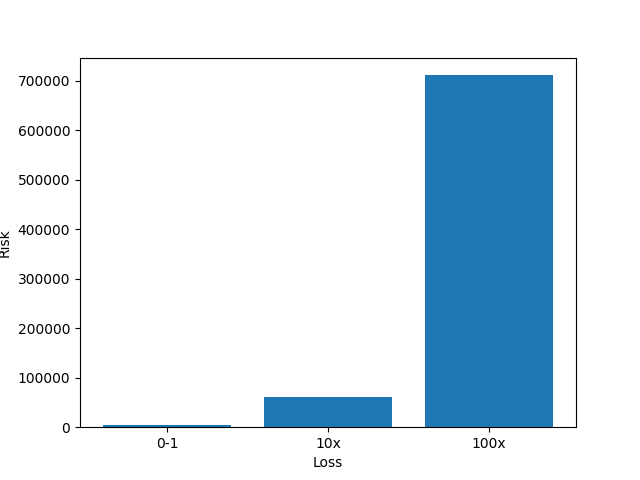

In [14]:
# estimate the minimum expected risk for each loss matrix
risk_1 = 0
risk_10 = 0
risk_100 = 0

# use the confusion matrices to estimate the minimum expected risk
for i in range(3):
    for j in range(3):
        risk_1 += confusion_matrix[i][j] * loss_1[i][j]
        risk_10 += confusion_matrix_10[i][j] * loss_10[i][j]
        risk_100 += confusion_matrix_100[i][j] * loss_100[i][j]

# normalize the risks
# risk_1 /= samples
# risk_10 /= samples
# risk_100 /= samples

# print the risks
print("The minimum expected risk for the 0-1 loss is", risk_1)
print("The minimum expected risk for the 10x loss is", risk_10)
print("The minimum expected risk for the 100x loss is", risk_100)

# plot the risks
fig = plt.figure()
plt.bar([1, 2, 3], [risk_1, risk_10, risk_100])
plt.xticks([1, 2, 3], ['0-1', '10x', '100x'])
plt.xlabel('Loss')
plt.ylabel('Risk')
plt.show()

We've calculated the minimum expected risk using each of the loss matrices. The notable distinction between these matrices is that they progressively care more about not making mistakes for Y = 3. As seen by the confusion matrix and the bar graph, this led to worse results as the loss matrix increased. For example, the confusion matrix for 100 has 0s all through the first column, meaning that for the true label Y = 1, there were no classifications for that label. This is because the loss matrix cared so much about not misclassifying label 3 that it would incorrectly bias towards classifying as 3. 

Another interesting note is that as the loss matrix increased, the number of correct classifications for label 3 increased. This came at a significant tradeoff, however, since it also meant that the number of incorrect classifications increased. Thus, it's important to consider all the effects of classification and not just focus on one number to determine success.